<a href="https://colab.research.google.com/github/hurshd0/DS-Unit-2-Kaggle-Challenge/blob/master/module1/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [X] Do train/validate/test split with the Tanzania Waterpumps data.
- [X] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [X] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [X] Get your validation accuracy score.
- [X] Get and plot your feature importances.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [X] Add your own stretch goal(s) !
- [X] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [X] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [X] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    # Remove content files
    !rm -rf content
    !mkdir content
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/hurshd0/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')
    !rm -rf eda.py
    !wget https://raw.githubusercontent.com/hurshd0/ds-cheat-sheets/master/eda.py

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 133kB 9.0MB/s 
     |████████████████████████████████| 7.1MB 43.6MB/s 
     |████████████████████████████████| 614kB 41.2MB/s 
     |████████████████████████████████| 225kB 42.8MB/s 
     |████████████████████████████████| 768kB 44.1MB/s 
     |████████████████████████████████| 51kB 19.6MB/s 
     |████████████████████████████████| 194kB 45.3MB/s 
     |████████████████████████████████| 737kB 41.4MB/s 
     |████████████████████████████████| 51kB 19.9MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=b0a11e48aaf5cf07bbf9bd0c5b03776dabb7b731928ada10ebc0a69b53a7e420
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=40bffb1f5c2a2193d4961cd6ae5ff43925eda94fd2a3fd049fe89f767089eb17
  Stored 

In [0]:
################################ EDA IMPORTS ###################################
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go # interactive low-level plotting lib https://plot.ly/python/
import plotly.express as px #high-level api wrapper for plotly https://plot.ly/python/plotly-express/#visualize-distributions
# ---------------- Plot libs settings ------------- #
plt.style.use('seaborn-darkgrid')
sns.set(context='notebook', style='darkgrid', palette='colorblind')
# Seting a universal figure size 
plt.rcParams['figure.figsize'] = (10, 6)

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# --------------------- Custom lib imports --------------#
import eda

# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')
################################################################################

# LOAD DATA

In [0]:
def load_dataset():
    train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
    test = pd.read_csv('../data/tanzania/test_features.csv')
    sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')
    print(f'''
    -------------------- SHAPE ---------------------
    Train Set: {train.shape}
    Test Set: {test.shape}
    Sample Submission: {sample_submission.shape}
    ------------------------------------------------
    ''')
    return (train, test, sample_submission)
traindf, testdf, sampledf = load_dataset()


    -------------------- SHAPE ---------------------
    Train Set: (59400, 41)
    Test Set: (14358, 40)
    Sample Submission: (14358, 2)
    ------------------------------------------------
    


# PEEK AT DATA

In [0]:
traindf.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# WRANGLE DATA

In [0]:
def wrangle(df):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    df = df.copy()

    # Remove duplicate columns and useless one
    useless_columns = ['recorded_by', 'quantity_group', 'num_private']
    df = df.drop(useless_columns, axis=1)

    # Set `id` to be the index
    df = df.set_index('id', drop=True)

    # Set correct data type for 
    ## - datetime columns
    df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True)
    ## - binary columns
    boolean_columns = ['permit', 'public_meeting']
    for col in boolean_columns:
        df[col] = df[col].astype(float)
    
    # Fix Null Island - latitudes and longitudes
    null_island = {'longitude':0, 'latitude':-2e-8}
    mask = (df['longitude'] == null_island['longitude']) & (df['latitude'] == null_island['latitude'])
    loc = 'region'
    locs = df.loc[mask, loc].unique()
    for k in null_island.keys():
        for loc_name in locs:
            df.loc[mask & (df[loc] == loc_name), k] = df[~mask].groupby(loc)[k].mean()[loc_name]

    # Clean numerical columns
    null_placeholders = {'amount_tsh':0, 'gps_height':0, 'population':0, 'construction_year':0}
    for col, null_val in null_placeholders.items():
        df[col] = df[col].replace(null_val, np.NaN)

    # Sanitize categorical columns
    categorical_columns = eda.get_categorical_columns(df)
    for col in categorical_columns:
        df[col] = df[col].str.strip().str.lower()
    
    # Clean low cardinality categorical columns
    min_card = 1
    max_card = 50
    low_card_cat_cols = [col for col in sorted(eda.get_categorical_columns(df)) if (df[col].nunique() > min_card) and (df[col].nunique() < max_card)]
    nan_labels = ['unknown', 'none', '0']
    for col in low_card_cat_cols:
        df[col] = df[col].replace(nan_labels, np.NaN)

    # Reduce high-cardinality columns
    high_card_cols = [col for col in df.describe(include=['object']).columns if df[col].nunique() > max_card]
    for col in high_card_cols:
        top10 = df[col].value_counts()[:10].index
        df.loc[~df[col].isin(top10), col] = 'other'
    # return the wrangled dataframe
    return df


train = wrangle(traindf)
test = wrangle(testdf)

print(f'''
------------ SHAPE ----------------
    Training Set: {train.shape}
    Test Set: {test.shape}
-----------------------------------
''')


------------ SHAPE ----------------
    Training Set: (59400, 37)
    Test Set: (14358, 36)
-----------------------------------



# Feature Generation

In [0]:
def feature_generation(df):
    # Add last_inspeaction_year and years_since_construction
    df['last_inspection_year'] = df['date_recorded'].dt.year
    df['years_since_construction'] = df['last_inspection_year'] - df['construction_year']
    df.loc[(df['years_since_construction'] < 0), 'years_since_construction'] = np.NaN
    df.loc[(df['years_since_construction'] > 100), 'years_since_construction'] = np.NaN
    return df

train = feature_generation(train)
test = feature_generation(test)
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,last_inspection_year,years_since_construction
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,other,1390.0,other,34.938093,-9.856322,none,lake nyasa,other,iringa,11,5,other,other,109.0,1.0,vwc,other,0.0,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,12.0
8776,NaN,2013-03-06,other,1399.0,other,34.698766,-2.147466,zahanati,lake victoria,other,mara,20,2,other,other,280.0,NaN,other,other,1.0,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2013,3.0
34310,25.0,2013-02-25,other,686.0,other,37.460664,-3.821329,other,pangani,majengo,manyara,21,4,other,other,250.0,1.0,vwc,other,1.0,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,2013,4.0
67743,NaN,2013-01-28,unicef,263.0,other,38.486161,-11.155298,other,ruvuma / southern coast,other,mtwara,90,63,other,other,58.0,1.0,vwc,other,1.0,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2013,27.0
19728,NaN,2011-07-13,other,NaN,other,31.130847,-1.825359,shuleni,lake victoria,other,kagera,18,1,other,other,NaN,1.0,NaN,other,1.0,NaN,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2011,NaN


# EDA 🌈

### Convert multi-class target to binary

In [0]:
edadf = train.copy()
for label in edadf['status_group'].unique():
    edadf[label] = (edadf['status_group']==label).astype(int)
edadf.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,last_inspection_year,years_since_construction,functional,non functional,functional needs repair
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,other,1390.0,other,34.938093,-9.856322,none,lake nyasa,other,iringa,11,5,other,other,109.0,1.0,vwc,other,0.0,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,12.0,1,0,0
8776,NaN,2013-03-06,other,1399.0,other,34.698766,-2.147466,zahanati,lake victoria,other,mara,20,2,other,other,280.0,NaN,other,other,1.0,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2013,3.0,1,0,0
34310,25.0,2013-02-25,other,686.0,other,37.460664,-3.821329,other,pangani,majengo,manyara,21,4,other,other,250.0,1.0,vwc,other,1.0,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,2013,4.0,1,0,0
67743,NaN,2013-01-28,unicef,263.0,other,38.486161,-11.155298,other,ruvuma / southern coast,other,mtwara,90,63,other,other,58.0,1.0,vwc,other,1.0,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2013,27.0,0,1,0
19728,NaN,2011-07-13,other,NaN,other,31.130847,-1.825359,shuleni,lake victoria,other,kagera,18,1,other,other,NaN,1.0,NaN,other,1.0,NaN,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2011,NaN,1,0,0


### LOCATION, LOCATION, LOCATION! 🌍

In [0]:
# https://plot.ly/python/mapbox-layers/#base-maps-in-layoutmapboxstyle
fig = px.scatter_mapbox(edadf, lat='latitude', lon='longitude', color='status_group', hover_data=['region'])
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

### Plot Categorical columns 📊

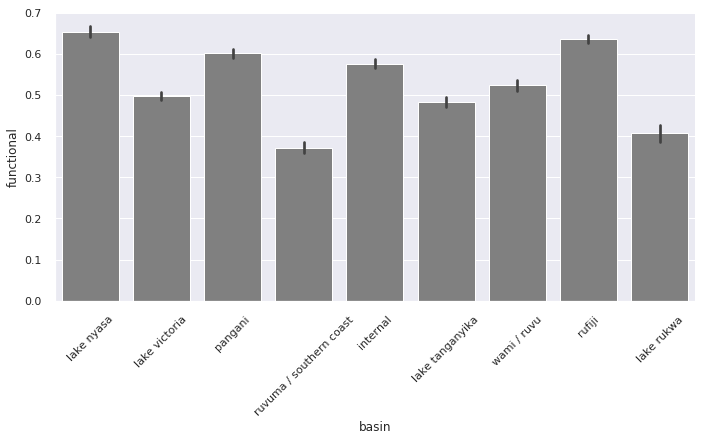

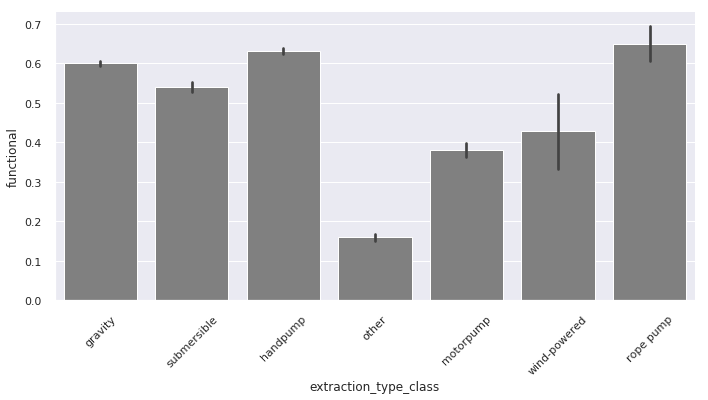

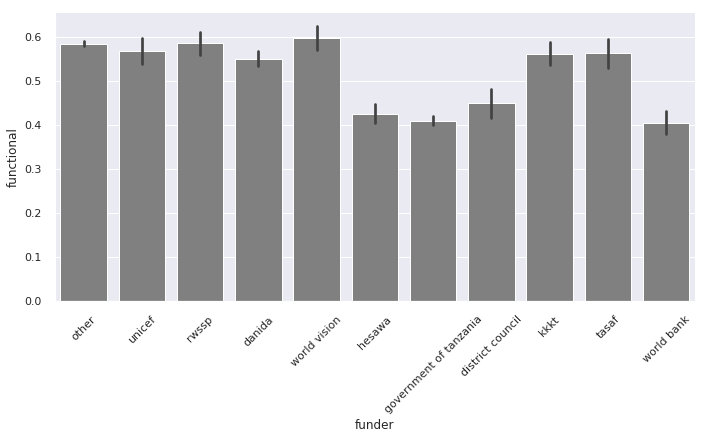

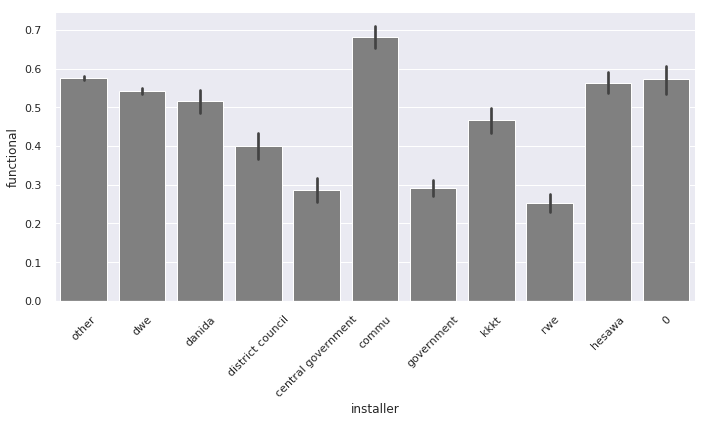

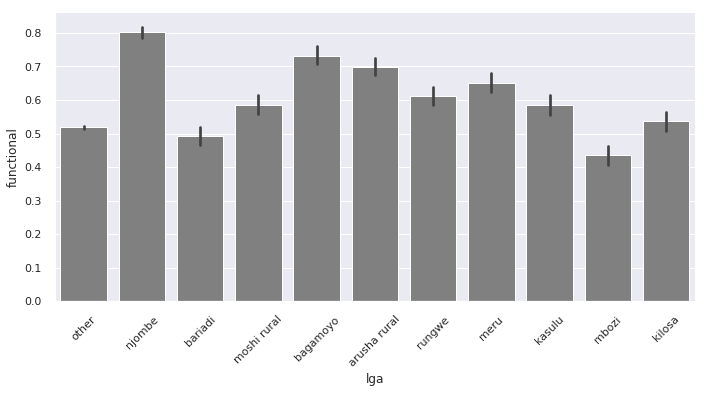

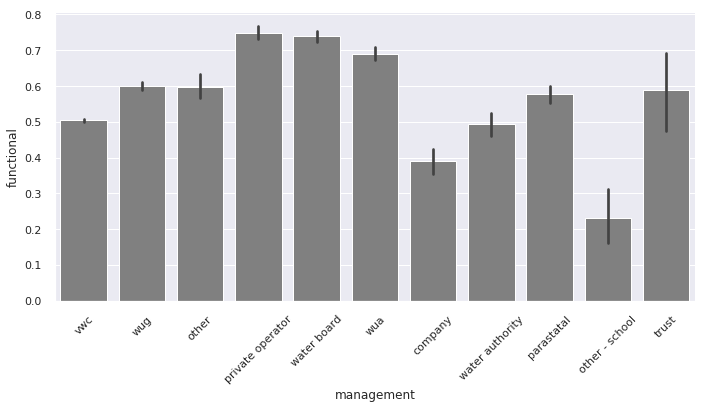

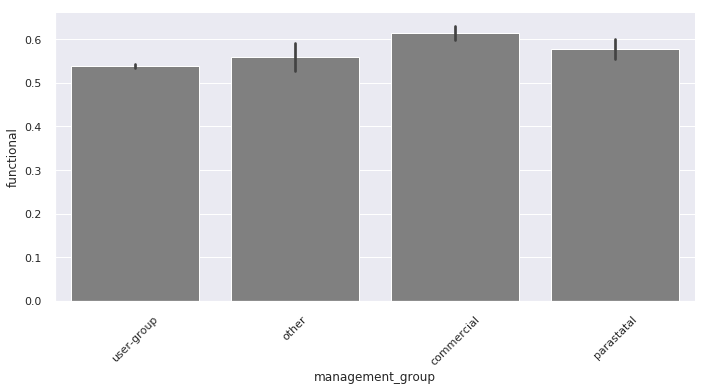

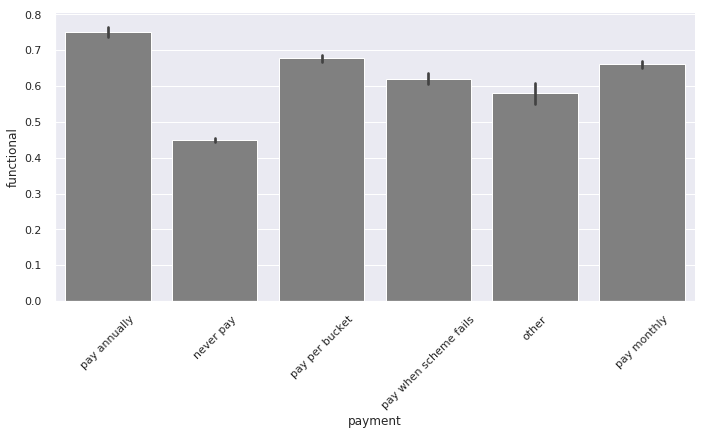

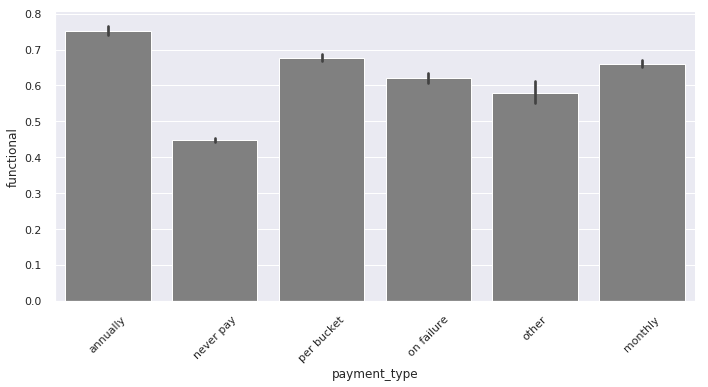

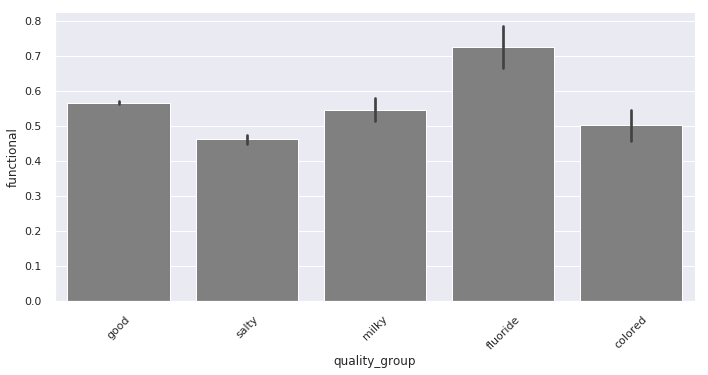

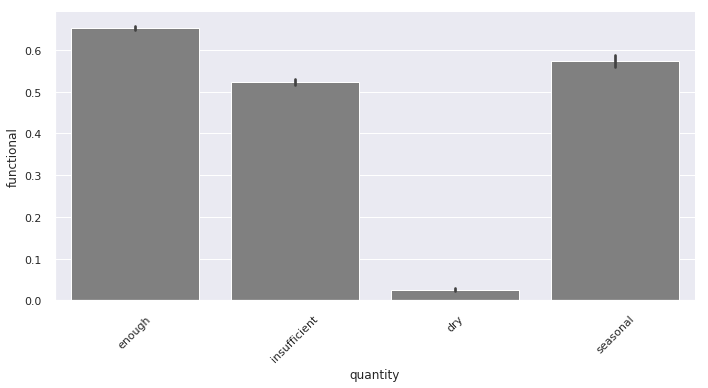

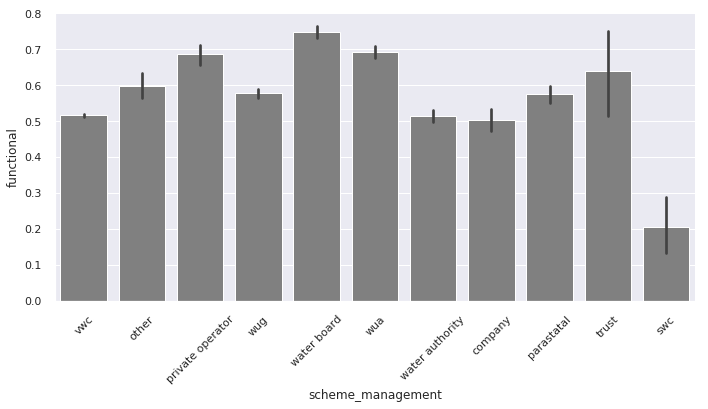

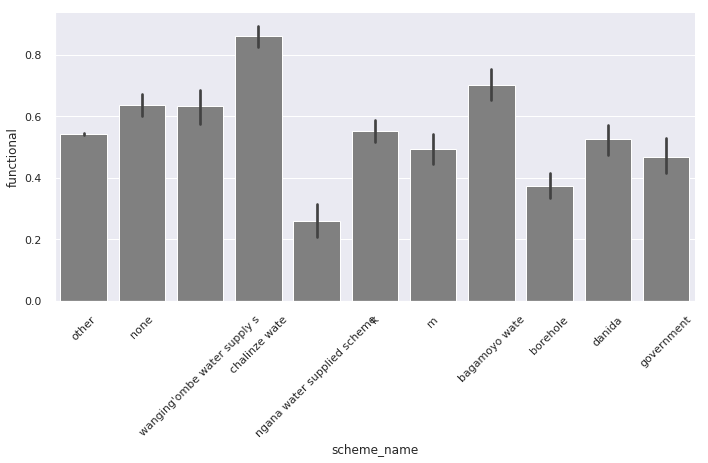

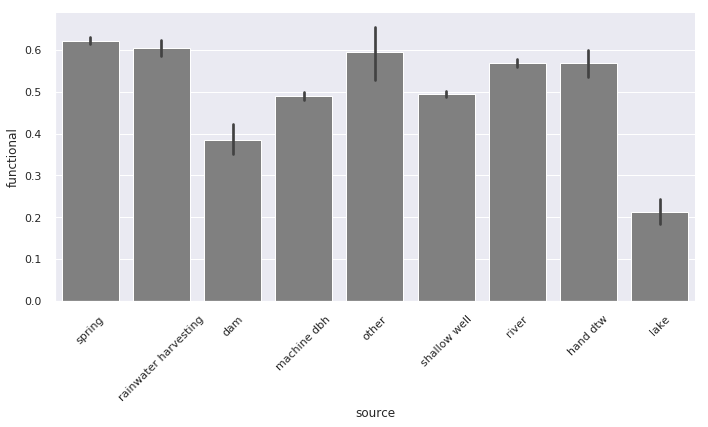

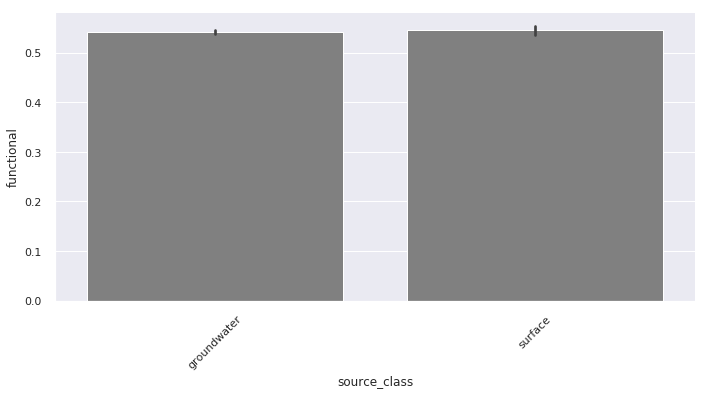

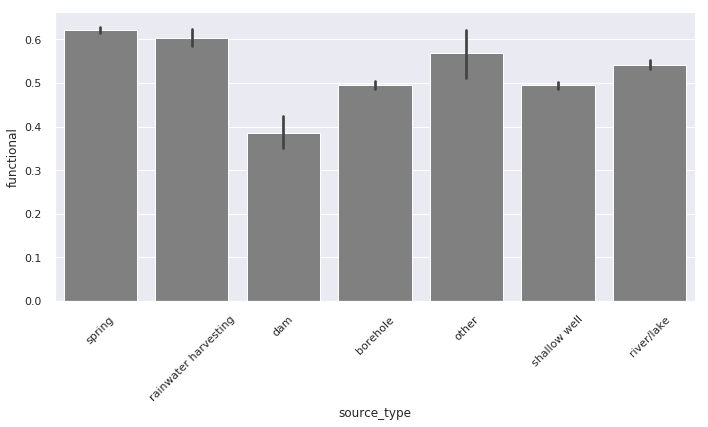

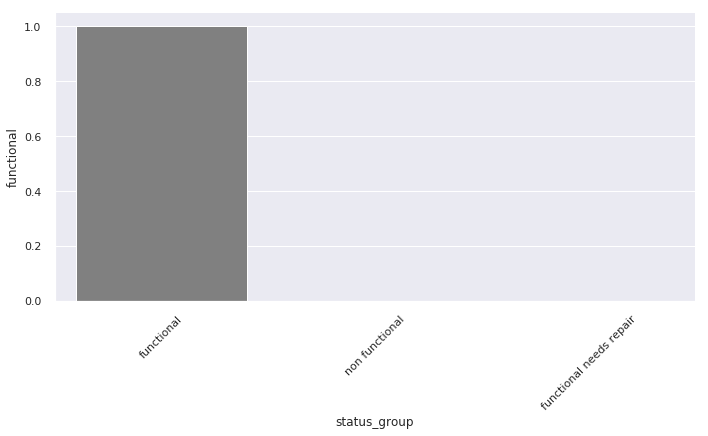

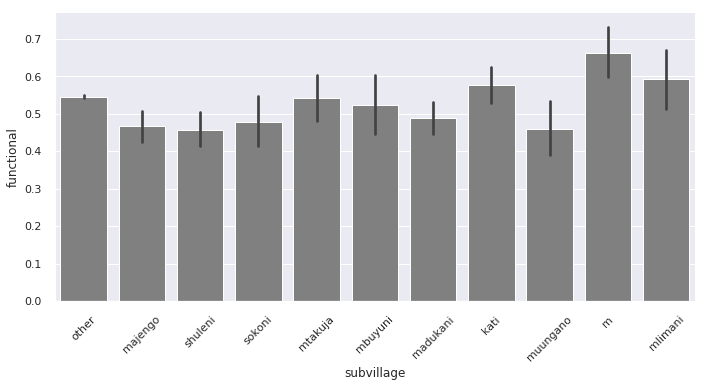

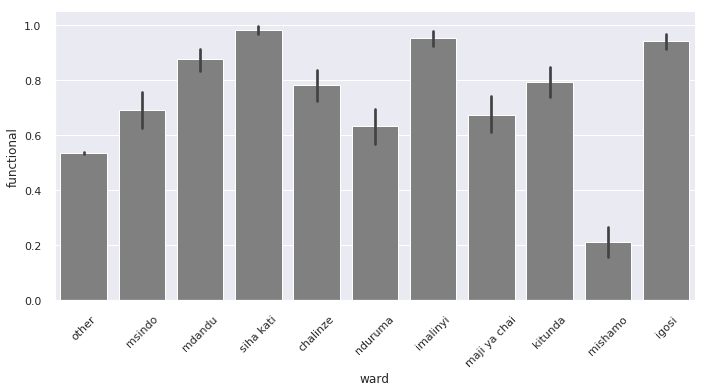

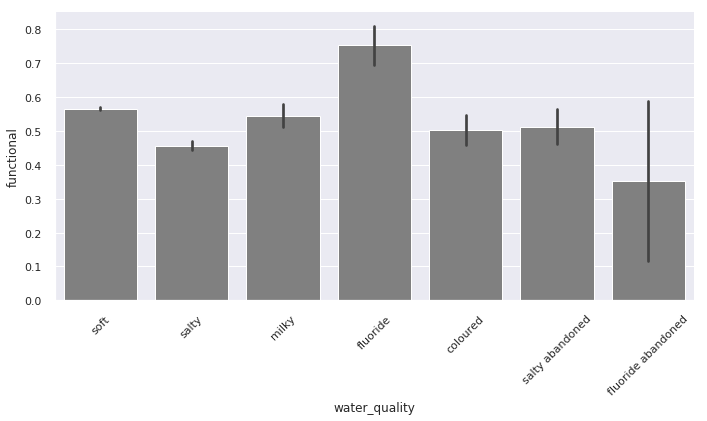

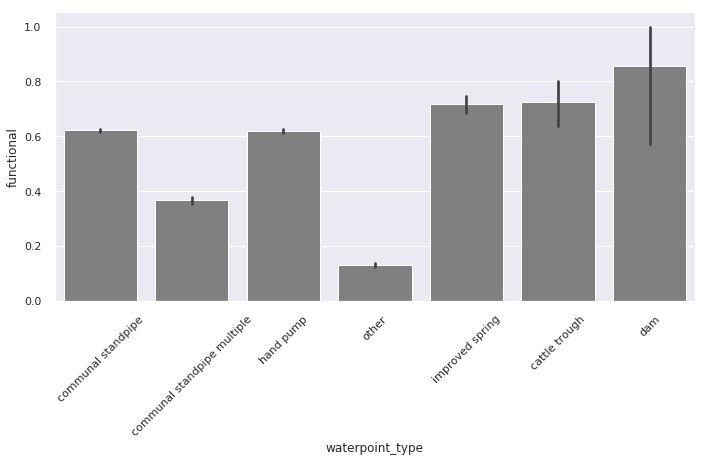

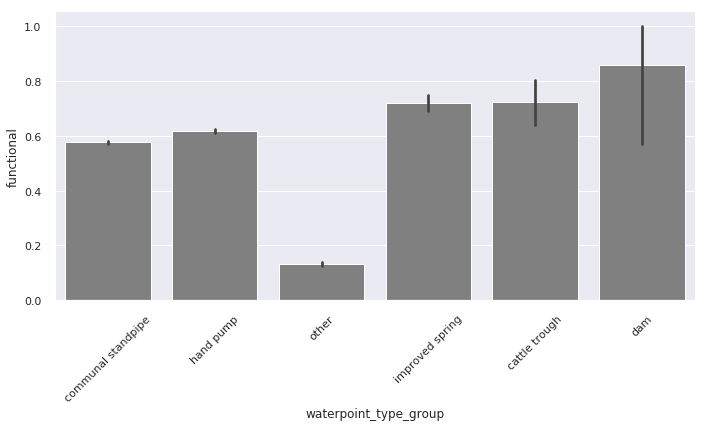

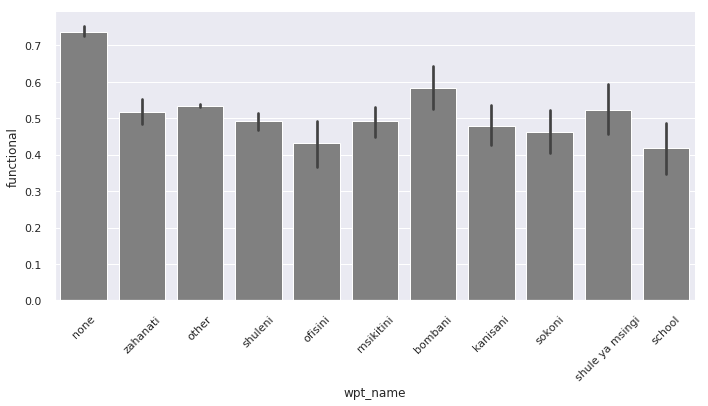

In [0]:
eda.plot_categorical__reg(edadf, 'functional')

# DECISION TREE CLASSIFIER


![](http://dataaspirant.com/wp-content/uploads/2017/01/B03905_05_01-compressor.png)

In [0]:
#################################### ML IMPORTS ################################
### Pre-Processing
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

### Train/Test - Split & CV
from sklearn.model_selection import train_test_split

### Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

### Post-processing
from sklearn.pipeline import make_pipeline

## TRAIN-VAL-SPLIT

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 39 columns):
amount_tsh                  17761 non-null float64
date_recorded               59400 non-null datetime64[ns]
funder                      59400 non-null object
gps_height                  38962 non-null float64
installer                   59400 non-null object
longitude                   59400 non-null float64
latitude                    59400 non-null float64
wpt_name                    59400 non-null object
basin                       59400 non-null object
subvillage                  59400 non-null object
region                      59400 non-null object
region_code                 59400 non-null int64
district_code               59400 non-null int64
lga                         59400 non-null object
ward                        59400 non-null object
population                  38019 non-null float64
public_meeting              56066 non-null float64
scheme_management        

In [0]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

print(train.shape, val.shape)

target = 'status_group'
exclude_cols = ['date_recorded']
exclude_cols.append(target)
features = [col for col in train.columns if col not in exclude_cols]
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

(47520, 39) (11880, 39)


((47520, 37), (47520,), (11880, 37), (11880,), (14358, 37))

In [0]:
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,last_inspection_year,years_since_construction
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
72938,NaN,other,NaN,other,33.542898,-9.174777,other,lake nyasa,other,mbeya,12,4,rungwe,other,NaN,1.0,vwc,k,NaN,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2011,NaN
65358,500.0,other,2049.0,other,34.665760,-9.308548,other,rufiji,other,iringa,11,4,njombe,imalinyi,175.0,1.0,wua,other,1.0,2008.0,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,3.0
469,25.0,other,290.0,other,38.238568,-6.179919,other,wami / ruvu,other,pwani,6,1,bagamoyo,other,2300.0,1.0,vwc,other,0.0,2010.0,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,2011,1.0
1298,NaN,government of tanzania,NaN,dwe,30.716727,-1.289055,other,lake victoria,other,kagera,18,1,other,other,NaN,1.0,NaN,other,1.0,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,2011,NaN
27001,NaN,other,NaN,other,35.389331,-6.399942,other,internal,other,dodoma,1,6,other,other,NaN,1.0,vwc,other,1.0,NaN,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,2011,NaN


### Baseline Decision Tree Classifier

In [0]:
# 1. One Hot encoding

encoder = ce.OneHotEncoder(use_cat_names=True, handle_missing='indicator')
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

def print_shape(train, val, title):
    print(
    '''------- SHAPE - {} ---------
    Training Set: {}
    Validation Set: {}
    '''.format(title, train.shape, val.shape))
print_shape(X_train_encoded, X_val_encoded, 'After One Hot Encoding')

------- SHAPE - After One Hot Encoding ---------
    Training Set: (47520, 267)
    Validation Set: (11880, 267)
    


In [0]:
# 2. Simple Imputing

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

print_shape(X_train_imputed, X_val_imputed, 'After One Hot Encoding')

------- SHAPE - After One Hot Encoding ---------
    Training Set: (47520, 267)
    Validation Set: (11880, 267)
    


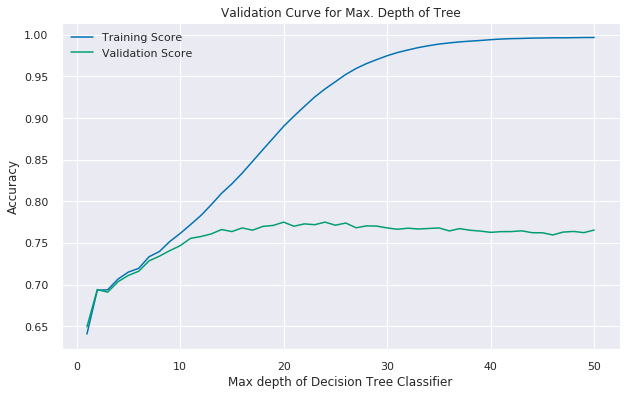

In [0]:
# 3. Create Model

max_depth = 50
depth_range = np.arange(1, max_depth+1)
seed = 42

results = {
    'depth':[],
    'train_score':[],
    'val_score':[]
}


for i in depth_range:
    clf = DecisionTreeClassifier(max_depth=i, random_state=seed)
    clf.fit(X_train_imputed, y_train)
    train_score = clf.score(X_train_imputed, y_train)
    val_score = clf.score(X_val_imputed, y_val)
    results['depth'].append(i)
    results['train_score'].append(train_score)
    results['val_score'].append(val_score)

plt.plot(results['depth'], results['train_score'], label='Training Score', color='b')
plt.plot(results['depth'], results['val_score'], label='Validation Score', color='g')
plt.ylabel("Accuracy")
plt.xlabel("Max depth of Decision Tree Classifier")
plt.legend()
plt.title('Validation Curve for Max. Depth of Tree')
plt.show();

### @ Best Max. depth 📏

In [0]:
best_depth = 20
clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
clf.fit(X_train_imputed, y_train)
val_score = clf.score(X_val_imputed, y_val)
print('At Max. Depth of - {}, Accuracy is - {}'.format(best_depth, val_score))

At Max. Depth of - 20, Accuracy is - 0.775


### @ Find Min. samples per 🍀🌱

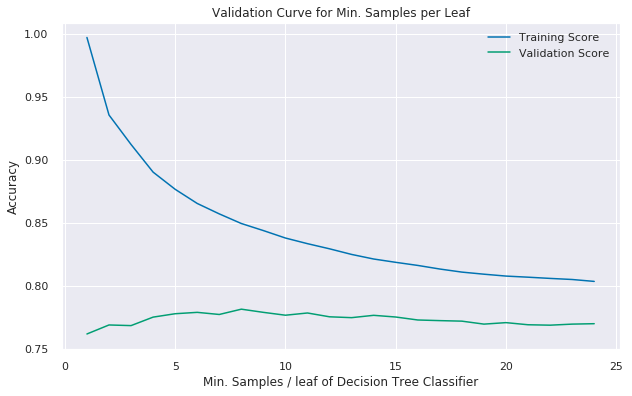

In [0]:
min_samples_leaf = 25
min_leaf_range = np.arange(1, min_samples_leaf, 1)
seed = 42

results = {
    'min_samples_leaf':[],
    'train_score':[],
    'val_score':[]
}


for i in min_leaf_range:
    clf = DecisionTreeClassifier(min_samples_leaf=i, random_state=seed)
    clf.fit(X_train_imputed, y_train)
    train_score = clf.score(X_train_imputed, y_train)
    val_score = clf.score(X_val_imputed, y_val)
    results['min_samples_leaf'].append(i)
    results['train_score'].append(train_score)
    results['val_score'].append(val_score)

plt.plot(results['min_samples_leaf'], results['train_score'], label='Training Score', color='b')
plt.plot(results['min_samples_leaf'], results['val_score'], label='Validation Score', color='g')
plt.ylabel("Accuracy")
plt.xlabel("Min. Samples / leaf of Decision Tree Classifier")
plt.legend()
plt.title('Validation Curve for Min. Samples per Leaf')
plt.show();

### @ Best Min. samples per leaf 🌱

In [0]:
best_min_samples_leaf = 8
clf = DecisionTreeClassifier(min_samples_leaf=best_min_samples_leaf, random_state=42)
clf.fit(X_train_imputed, y_train)
val_score = clf.score(X_val_imputed, y_val)
print('At Min. Samples per Leaf of - {}, Accuracy is - {}'.format(best_min_samples_leaf, val_score))

At Min. Samples per Leaf of - 8, Accuracy is - 0.7813131313131313


### @ Combined score 🎯

In [0]:
clf = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
clf.fit(X_train_imputed, y_train)
val_score = clf.score(X_val_imputed, y_val)
print('Combined Accuracy Score: {}'.format(val_score))

Combined Accuracy Score: 0.77996632996633


### @ Feature Importance 📋

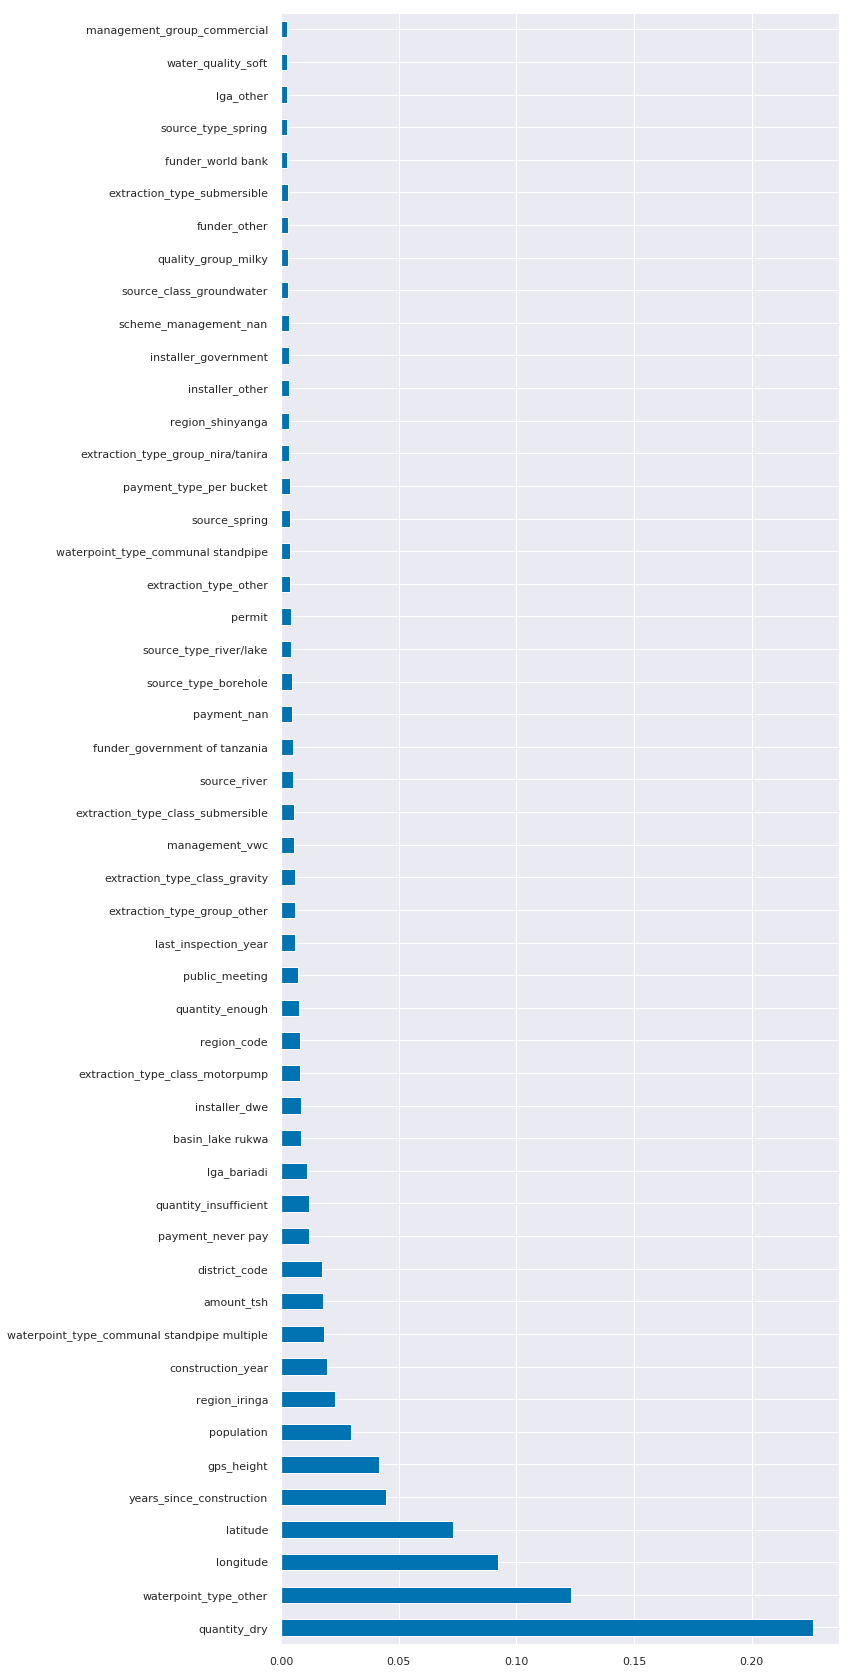

In [0]:
encoded_columns = X_train_encoded.columns
feat_importances = pd.Series(clf.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
feat_importances.sort_values(ascending=False)[:50].plot.barh();

### @ Combine into Pipeline 🚅

In [0]:
best_min_samples_leaf = 8
best_depth = 20

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, handle_missing='indicator'), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
)

pipeline.fit(X_train, y_train)
print('==== Combining into Pipeline ====')
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

==== Combining into Pipeline ====
Train Accuracy 0.8302819865319865
Validation Accuracy 0.77996632996633


### @@ Try Out: OrdinalEncoder

In [0]:
best_min_samples_leaf = 8
best_depth = 20

pipeline = make_pipeline(
    ce.OrdinalEncoder(handle_missing='indicator'), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
)
pipeline.fit(X_train, y_train)
print('Simple Imputer (mean) - with Ordinal Encoding')
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Simple Imputer (mean) - with Ordinal Encoding
Train Accuracy 0.8470959595959596
Validation Accuracy 0.7745791245791246


### @@ Try Out: Iterative Imputer

In [0]:
best_min_samples_leaf = 8
best_depth = 20

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, handle_missing='indicator'),  
    IterativeImputer(random_state=42), 
    DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Iterative Imputer - with One-Hot Encoding')
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Iterative Imputer - with One-Hot Encoding
Train Accuracy 0.8335227272727272
Validation Accuracy 0.7707912457912458


In [0]:
best_min_samples_leaf = 8
best_depth = 20

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True, handle_missing='indicator'),  
    IterativeImputer(random_state=42), 
    DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Iterative Imputer - with Ordinal Encoding')
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Iterative Imputer - with Ordinal Encoding
Train Accuracy 0.8335227272727272
Validation Accuracy 0.7707912457912458


### @@ Target 🎯 Encoder

In [0]:
# 1. Target Encoding
y_train_b = (train['status_group'] == 'functional').astype(int)
target_encoder = ce.TargetEncoder(handle_missing='indicator')
X_train_encoded_te = target_encoder.fit_transform(X_train, y_train_b)
X_val_encoded_te = target_encoder.transform(X_val)
X_test_encoded_te = target_encoder.transform(X_test)
X_train_encoded_te.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,last_inspection_year,years_since_construction
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
72938,NaN,0.584451,NaN,0.577633,33.542898,-9.174777,0.533799,0.653497,0.545263,0.498245,12,4,0.601130,0.534033,NaN,1.0,0.516322,0.536364,NaN,NaN,0.599403,0.599403,0.599403,0.504792,0.538178,0.448317,0.448317,0.566407,0.566407,0.521106,0.621880,0.621880,0.54146,0.622706,0.577635,2011,NaN
65358,500.0,0.584451,2049.0,0.577633,34.665760,-9.308548,0.533799,0.636307,0.545263,0.786588,11,4,0.809785,0.956938,175.0,1.0,0.690231,0.542120,1.0,2008.0,0.599403,0.599403,0.599403,0.691105,0.538178,0.663305,0.663305,0.566407,0.566407,0.650920,0.621880,0.621880,0.54146,0.622706,0.577635,2011,3.0
469,25.0,0.584451,290.0,0.577633,38.238568,-6.179919,0.533799,0.521265,0.545263,0.589573,6,1,0.728984,0.534033,2300.0,1.0,0.516322,0.542120,0.0,2010.0,0.608402,0.608402,0.629854,0.504792,0.538178,0.676861,0.676861,0.452472,0.456569,0.521106,0.491893,0.491893,0.54146,0.617125,0.617125,2011,1.0
1298,NaN,0.411283,NaN,0.540558,30.716727,-1.289055,0.533799,0.500061,0.545263,0.525813,18,1,0.519456,0.534033,NaN,1.0,0.484180,0.542120,1.0,NaN,0.159060,0.159060,0.159060,0.504792,0.538178,0.448317,0.448317,0.566407,0.566407,0.650920,0.491893,0.491893,0.54146,0.128649,0.128649,2011,NaN
27001,NaN,0.584451,NaN,0.577633,35.389331,-6.399942,0.533799,0.574580,0.545263,0.448529,1,6,0.519456,0.534033,NaN,1.0,0.516322,0.542120,1.0,NaN,0.379036,0.379036,0.380892,0.504792,0.538178,0.676861,0.676861,0.566407,0.566407,0.650920,0.491206,0.496688,0.54146,0.622706,0.577635,2011,NaN


In [0]:
# 2. Iterative Imputer

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded_te)
X_val_imputed = imputer.transform(X_val_encoded_te)
X_test_imputed = imputer.transform(X_test_encoded_te)

# 3. DecisionTreeClassifier
best_min_samples_leaf = 8
best_depth = 20

clf = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
clf.fit(X_train_imputed, y_train)
train_score = clf.score(X_train_imputed, y_train)
val_score = clf.score(X_val_imputed, y_val)

print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

Training Score: 0.8459385521885522
Validation Score: 0.7781144781144781


### Kaggle Submission ☑

In [0]:
def kaggle_submission(model, X_test, submission):
    import datetime, sys
    in_colab = 'google.colab' in sys.modules
    y_pred = model.predict(X_test)
    submission['status_group'] = y_pred
    file_name = 'submission-{}.csv'.format(datetime.datetime.now().strftime('%Y-%m-%d'))
    submission.to_csv(file_name, index=False)
    if in_colab:
        from google.colab import files
        # Just try again if you get this error:
        # TypeError: Failed to fetch
        # https://github.com/googlecolab/colabtools/issues/337
        try:
            files.download(file_name)
        except Exception as e:
            print('Try it again if you get: Type Error: NetworkError when attempting to fetch resource.')
            print(e)

#### @ Final Submission

In [0]:
from ipywidgets import interact

def fine_tune_params(max_depth, min_samples_leaf):
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    clf.fit(X_train_imputed, y_train)
    train_score = clf.score(X_train_imputed, y_train)
    val_score = clf.score(X_val_imputed, y_val)
    print('Training Score: {}'.format(train_score))
    print('Validation Score: {}'.format(val_score))

interact(fine_tune_params, max_depth=(1, 25, 1), min_samples_leaf=(1, 25, 1));

interactive(children=(IntSlider(value=13, description='max_depth', max=25, min=1), IntSlider(value=13, descrip…

In [0]:
clf = DecisionTreeClassifier(max_depth=18, min_samples_leaf=10, random_state=42)
clf.fit(X_train_imputed, y_train)
train_score = clf.score(X_train_imputed, y_train)
val_score = clf.score(X_val_imputed, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

Training Score: 0.8327020202020202
Validation Score: 0.7790404040404041


#### @ Checking to see if Scaling Helps

In [0]:
# 1. Encoder
y_train_b = (train['status_group'] == 'functional').astype(int)
target_encoder = ce.TargetEncoder(handle_missing='indicator')
X_train_encoded_te = target_encoder.fit_transform(X_train, y_train_b)
X_val_encoded_te = target_encoder.transform(X_val)
X_test_encoded_te = target_encoder.transform(X_test)

# 2. Imputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded_te)
X_val_imputed = imputer.transform(X_val_encoded_te)
X_test_imputed = imputer.transform(X_test_encoded_te)

# 3. Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_imputed = scaler.transform(X_test_imputed)

# 4. DT Classifier
clf = DecisionTreeClassifier(max_depth=18, min_samples_leaf=10, random_state=42)
clf.fit(X_train_scaled, y_train)
train_score = clf.score(X_train_scaled, y_train)
val_score = clf.score(X_val_scaled, y_val)
print('Training Score: {}'.format(train_score))
print('Validation Score: {}'.format(val_score))

Training Score: 0.8327020202020202
Validation Score: 0.778956228956229


It doesn't seem like scaling helps in Decision Tree unlike in Logistic Regression.